In [1]:
import os
from glob import glob
import torch
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityRanged,
    CropForegroundd,
    Spacingd,
    ToTensord,
    Resized,
    Orientationd
)
from monai.data import Dataset, DataLoader
from monai.networks.nets import UNet 
from monai.networks.layers import Norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import nibabel as nib

In [2]:
from pathlib import Path
import nibabel as nib
import os

LABEL_DIR = Path(
    r"C:/Users/skan2/OneDrive/Desktop/Epilepsy_well_structured/prepared_ds/labelsTr"
)

removed_files = []

for file_path in LABEL_DIR.glob("*"):
    if not file_path.is_file():
        continue

    try:
        nib.load(str(file_path))
    except Exception as e:
        print(f"REMOVING BAD FILE: {file_path.name}")
        print(f"  Reason: {e}")
        os.remove(file_path)
        removed_files.append(file_path.name)

print("\nCleanup complete.")
print(f"Total files removed: {len(removed_files)}")

if removed_files:
    print("Removed files:")
    for f in removed_files:
        print(" -", f)



Cleanup complete.
Total files removed: 0


In [3]:
IMAGE_DIR = Path(
    r"C:/Users/skan2/OneDrive/Desktop/Epilepsy_well_structured/prepared_ds/imagesTr"
)

for file_path in IMAGE_DIR.glob("*"):
    try:
        nib.load(str(file_path))
    except Exception as e:
        print(f"REMOVING BAD IMAGE: {file_path.name}")
        os.remove(file_path)


In [3]:
dir = 'C:/Users/skan2/OneDrive/Desktop/Epilepsy_well_structured/prepared_ds'

train_image_set = len(os.listdir(os.path.join(dir, 'imagesTr')))*0.8
train_label_set = len(os.listdir(os.path.join(dir, 'labelsTr')))*0.8
val_image_set = len(os.listdir(os.path.join(dir, 'imagesTr')))*0.1
val_label_set = len(os.listdir(os.path.join(dir, 'labelsTr')))*0.1

images = sorted(glob(os.path.join(dir, 'imagesTr', '*.nii.gz')))
labels = sorted(glob(os.path.join(dir, 'labelsTr', '*.nii.gz')))

train_files = [{'image': img, 'label': lbl} for img, lbl in zip(images[:int(train_image_set)+1], labels[:int(train_label_set)+1])]
val_files = [{'image': img, 'label': lbl} for img, lbl in zip(images[:int(val_image_set)+1], labels[:int(val_label_set)+1])]


In [4]:
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),

    Spacingd(
        keys=["image", "label"],
        pixdim=(1.0, 1.0, 1.0),
        mode=("bilinear", "nearest"),
        diagonal=True
    ),

    CropForegroundd(
        keys=["image", "label"],
        source_key="image"
    ),

    Resized(
        keys=["image", "label"],
        spatial_size=(128, 128, 64),
        mode=("trilinear", "nearest")
    ),

    ScaleIntensityRanged(
        keys=["image"],
        a_min=-200,
        a_max=200,
        b_min=0.0,
        b_max=1.0,
        clip=True
    ),

    ToTensord(keys=["image", "label"]),
])

val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),

    Spacingd(
        keys=["image", "label"],
        pixdim=(1.0, 1.0, 1.0),
        mode=("bilinear", "nearest"),
        diagonal=True
    ),

    CropForegroundd(
        keys=["image", "label"],
        source_key="image"
    ),

    Resized(
        keys=["image", "label"],
        spatial_size=(128, 128, 64),
        mode=("trilinear", "nearest")
    ),

    ScaleIntensityRanged(
        keys=["image"],
        a_min=-200,
        a_max=200,
        b_min=0.0,
        b_max=1.0,
        clip=True
    ),

    ToTensord(keys=["image", "label"]),
])


c:\Users\skan2\OneDrive\Desktop\Epilepsy_well_structured\myenv\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


In [5]:
train_dataset = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataset = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [20]:
from utilities import train, show_patient

import torch
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,   # ✅ single-channel
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH
).to(device)

data_in = (train_loader, val_loader)

loss_function = DiceLoss(
    sigmoid=True,     # ✅ REQUIRED for out_channels=1
    squared_pred=False
)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-5,
    weight_decay=1e-5
)
model_dir = r"C:/Users/skan2/OneDrive/Desktop/Epilepsy_well_structured/model_dir"


In [ ]:
if __name__ == "__main__":
    train(model, data_in, loss_function, optimizer, 5, model_dir)

In [26]:
model.load_state_dict(
    torch.load(
        r"C:/Users/skan2/OneDrive/Desktop/Epilepsy_well_structured/model_dir/best_metric_model.pth",
        map_location=device
    )
)

model.eval()  # VERY IMPORTANT


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [36]:
from monai.utils import first

sample = first(val_loader)


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sample = first(val_loader)
image = sample["image"].to(device)
label = sample["label"].to(device)


In [38]:
with torch.no_grad():
    pred = model(image)
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()


In [39]:
img_np = image[0, 0].cpu().numpy()   # [H, W, D]
pred_np = pred[0, 0].cpu().numpy()   # [H, W, D]
gt = label[0, 0].cpu().numpy()
slice_idx = img_np.shape[2] // 2



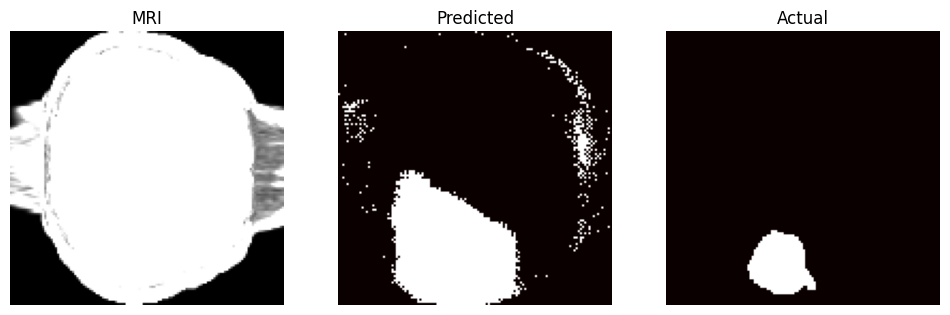

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("MRI")
plt.imshow(img_np[:, :, slice_idx], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Predicted")
plt.imshow(pred_np[:, :, slice_idx], cmap="hot")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Actual")
plt.imshow(gt[:, :, slice_idx], cmap="hot")
plt.axis("off")

plt.show()
